### https://cloud.tencent.com/developer/article/1922442

In [40]:
setwd('/import/DB/zhang//data')
library(Seurat)

In [41]:
sce = readRDS('OBcell.final.rds')

In [42]:
library(clusterProfiler)
library(org.Hs.eg.db)

In [43]:
DefaultAssay(sce) ='RNA'

In [44]:
table(sce$celltype)


 Inter_OB normal_OB tumor_OB1 tumor_OB2 
      919       421       880       689 

In [45]:
Idents(sce) = 'celltype'

In [46]:
sce = subset(sce,idents = c('Inter_OB','normal_OB'))

In [47]:
DefaultAssay(sce) = 'RNA'

In [48]:
Idents(sce)='celltype'
deg=FindMarkers(object = sce, ident.1 = 'Inter_OB',ident.2 = 'normal_OB',
 min.pct = 0.01, logfc.threshold = 0.01,
 thresh.use = 0.99)
head(deg)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEPT7,1.741717e-148,-2.213933,0.012,0.644,3.512696e-144
CTGF,1.290105e-143,-2.321949,0.004,0.599,2.601884e-139
SNHG29,5.358895e-141,2.322973,0.927,0.088,1.080782e-136
MINOS1,6.632079e-137,-2.162814,0.009,0.594,1.337558e-132
WIF1,7.410520e-130,-2.313463,0.024,0.591,1.494554e-125
NME2,3.333700e-119,1.881239,0.924,0.188,6.723406e-115


In [49]:
padj = 0.05
foldChange = 0.25

In [50]:
head(deg,2)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEPT7,1.741717e-148,-2.213933,0.012,0.644,3.512696e-144
CTGF,1.290105e-143,-2.321949,0.004,0.599,2.601884e-139


In [51]:
deg$group = as.factor(ifelse(deg$p_val_adj < padj & abs(deg$avg_log2FC) >= foldChange, 
                                 ifelse(deg$avg_log2FC> foldChange ,'Up','Down'),'NoSignifi'))

In [52]:
table(deg$group)


     Down NoSignifi        Up 
      777     11797      1741 

In [53]:
res = deg

In [54]:
library(dplyr)


Attaching package: 'dplyr'


The following object is masked from 'package:AnnotationDbi':

    select


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [55]:
top_5 <- bind_rows(   
      res %>%
        filter(group == 'Up') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10),
      res %>%
        filter(group == 'Down') %>%
        arrange(p_val_adj, desc(avg_log2FC)) %>%
        head(10)
    )

In [56]:
library(ggpubr)
library(ggplot2)
    library(dplyr)
    library(ggrepel)
    library(ggplot2)
    library(cowplot)

Warning message:
"package 'ggpubr' was built under R version 4.2.3"

Attaching package: 'ggpubr'


The following object is masked from 'package:enrichplot':

    color_palette


Warning message:
"package 'ggrepel' was built under R version 4.2.3"
Warning message:
"package 'cowplot' was built under R version 4.2.3"

Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




In [59]:
options(repr.plot.height = 6,repr.plot.width = 6)

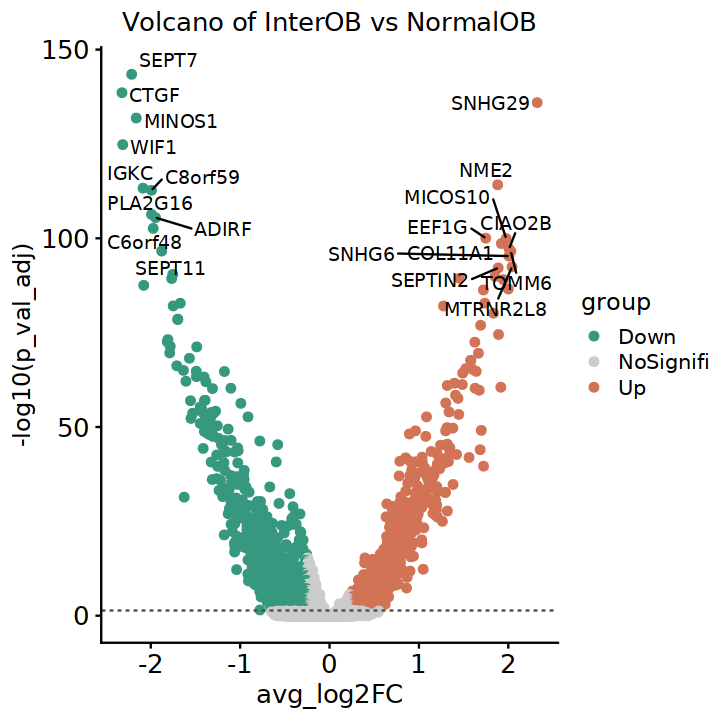

In [61]:

    ggplot(data=res,aes(x=avg_log2FC,y=-log10(p_val_adj)))+
    geom_point(aes(color=group),size=2)+
    geom_hline(yintercept = -log10(0.05), linetype="dashed",color="grey30")+
    #geom_vline(xintercept = c(-.8,.8),linetype="dashed",color="grey30")+
    geom_text_repel(data=top_5,aes(x= avg_log2FC,y= -log10(p_val_adj),label= rownames(top_5)),max.overlaps = 100)+
    scale_color_manual(values = c("#35987F","grey80","#D27356"))+
    theme_half_open() +
  theme(axis.title.x = element_text(size = 15))+
  theme(axis.text.x = element_text(size = 15))+
  theme(axis.text.y = element_text(size = 15))+
  theme(plot.title = element_text(size = 15,face = 4, hjust =0.5))+
  ggtitle("Volcano of InterOB vs NormalOB") 
    ggsave('Volcano.pdf',height = 8,width = 8)
    
   

In [62]:
dim(deg)

[1] 14315     6

In [63]:
diffgene = deg

In [64]:
library(clusterProfiler)
library(enrichplot)
library(org.Mm.eg.db)
#为每个基因添加对应的ENTREZID
diffgene$gene <- rownames(diffgene)
ids=bitr(diffgene$gene,'SYMBOL','ENTREZID','org.Hs.eg.db')
#合并数据，cluser3.markers中没有ENTREZID的基因将被过虑掉
diffgene=merge(diffgene,ids,by.x='gene',by.y='SYMBOL')

head(diffgene)

cluster3.markers = diffgene

#将基因按照avg_log2FC的大小进行降序排列
cluster3.markers <- cluster3.markers[order(cluster3.markers$avg_log2FC,decreasing = T),]
#生成仅含有ENTREZID名字和avg_log2FC值的gene list
cluster3.markers_list <- as.numeric(cluster3.markers$avg_log2FC)
names(cluster3.markers_list) <- cluster3.markers$ENTREZID
head(cluster3.markers_list)

#筛选差异较大的基因集
cluster3_de <- names(cluster3.markers_list)[abs(cluster3.markers_list) > 0.15]
head(cluster3_de)

length(cluster3_de)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(diffgene$gene, "SYMBOL", "ENTREZID", "org.Hs.eg.db"):
"10.11% of input gene IDs are fail to map..."


,gene,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,group,ENTREZID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,A1BG,9.716263e-01,-0.06873513,0.094,0.093,1.000000e+00,NoSignifi,1
2,A1BG-AS1,1.440298e-01,0.03914447,0.010,0.002,1.000000e+00,NoSignifi,503538
3,A2M,1.025834e-23,-0.72961475,0.333,0.558,2.068902e-19,Down,2
4,A2M-AS1,3.110612e-01,-0.03565914,0.007,0.012,1.000000e+00,NoSignifi,144571
5,A4GALT,2.621263e-03,-0.25118701,0.070,0.116,1.000000e+00,NoSignifi,53947
6,AAAS,2.510139e-06,0.17298571,0.194,0.083,5.062447e-02,NoSignifi,8086


125144 100463486 100188893     51647    641638     10631 
 2.322973  2.041743  2.028327  2.008749  2.007452  2.000035

[1] "125144"    "100463486" "100188893" "51647"     "641638"    "10631"

[1] 5756

In [65]:
cluster3_gsekg <- gseKEGG(cluster3.markers_list,organism = "hsa",pvalueCutoff = 0.05)
#将富集结果按照NES绝对值降序排列
cluster3_gsekg_arrange <- arrange(cluster3_gsekg,desc(abs(NES)))
head(cluster3_gsekg_arrange)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
"There are ties in the preranked stats (0.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results."
leading edge analysis...

done...



,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
hsa04974,hsa04974,Protein digestion and absorption,56,0.7029233,2.361423,1.074081e-08,3.587432e-06,2.973510e-06,1141,"tags=46%, list=9%, signal=42%",1301/1300/1306/1293/1290/1289/1281/7373/1307/1284/1303/2006/6510/1282/1280/1291/1294/3783/5547/1296/6520/80781/1277/23428/1292/6546
hsa00510,hsa00510,N-Glycan biosynthesis,47,0.6574524,2.132989,4.256313e-06,2.030869e-04,1.683324e-04,3284,"tags=66%, list=26%, signal=49%",58505/84061/6185/6184/3703/11253/8704/10195/199857/8818/1650/23193/79644/201595/85365/2683/7841/4121/1603/4247/7991/4245/79796/8813/11282/1798/29880/2530/4249/84620/79087
hsa05143,hsa05143,African trypanosomiasis,20,-0.7720461,-2.062104,1.361384e-05,5.018522e-04,4.159695e-04,77,"tags=25%, list=1%, signal=25%",3553/7412/3039/3040/3043
hsa05100,hsa05100,Bacterial invasion of epithelial cells,65,0.5854964,2.024375,1.502551e-05,5.018522e-04,4.159695e-04,1678,"tags=37%, list=13%, signal=32%",4735/55752/857/10801/23607/858/3678/10095/1212/10459/1213/2335/5296/3688/23176/1759/10552/998/8976/1731/81873/10097/10096/9564
hsa00513,hsa00513,Various types of N-glycan biosynthesis,36,0.6519401,2.006521,1.784642e-04,4.585158e-03,3.800493e-03,2284,"tags=58%, list=18%, signal=48%",58505/84061/6185/6184/3703/11253/8704/10195/199857/3073/1650/201595/85365/2683/284004/4121/1603/4247/7991/4245/79796
hsa05110,hsa05110,Vibrio cholerae infection,39,0.6345144,2.004900,8.742892e-05,2.654660e-03,2.200364e-03,2028,"tags=56%, list=16%, signal=48%",5336/527/11015/9601/30001/533/11014/29927/10945/9296/51382/23480/9550/375/10952/529/528/9414/523/8992/9114/109


In [66]:
df = cluster3_gsekg_arrange@result

In [67]:
library(ggplot2)
library(ggstatsplot)

In [68]:
options(repr.plot.width = 12,repr.plot.height = 5)

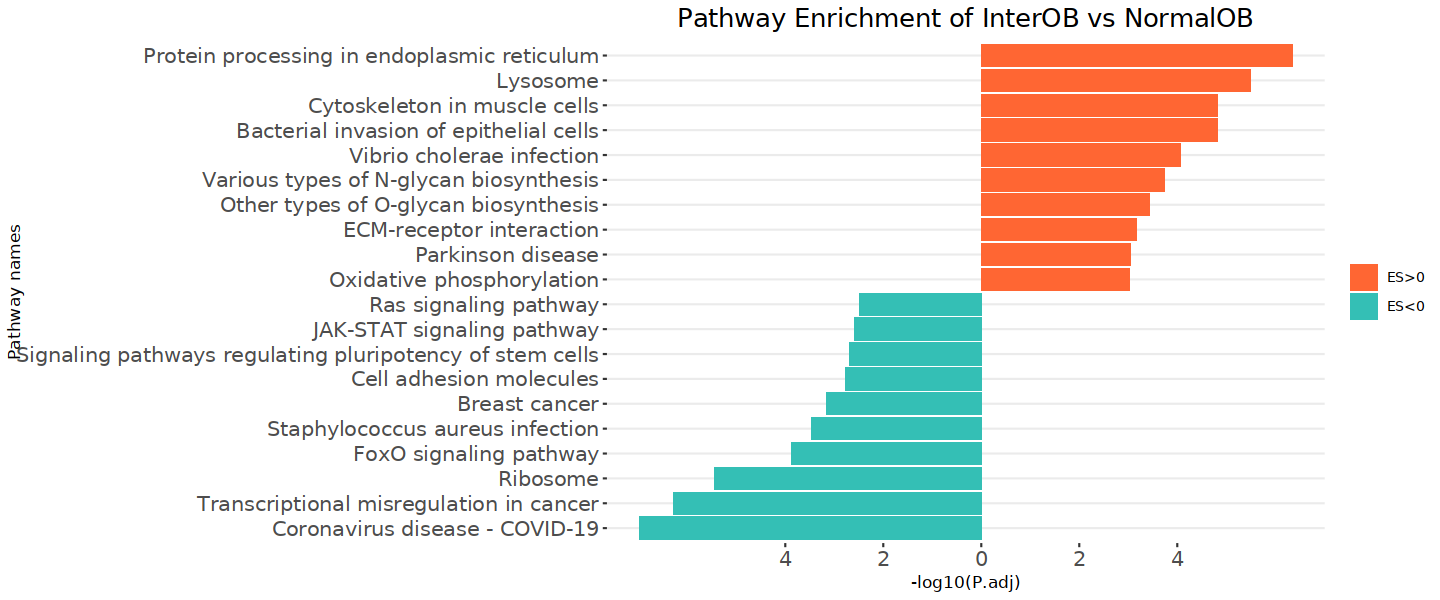

In [69]:
df = df[order(df$enrichmentScore),]
#设定分组：1--ES>0;   -1--ES<0
up = head(subset(df, enrichmentScore>0),10);up$group=1
down = tail(subset(df, enrichmentScore<0),10);down$group=-1
dat=rbind(up,down)
#dat$group = factor(dat$group);str(dat)
dat$pvalue = -log10(dat$pvalue)
dat$pvalue=dat$pvalue*dat$group 
dat=dat[order(dat$pvalue,decreasing = F),]
ggplot(dat, aes(x=reorder(Description,order(pvalue, decreasing = F)), y=pvalue, fill=group)) + 
  geom_bar(stat="identity", aes(fill=factor(group, levels = c(1,-1),  
                                            labels = c("ES>0","ES<0")))) + 
  xlab("Pathway names") +
  ylab("-log10(P.adj)") +
  coord_flip() + 
  theme_ggstatsplot() +
  scale_y_continuous(breaks=c(-4, -2, 0, 2, 4),
                     labels=c("4", "2", "0","2","4")) +
  scale_fill_manual(values = c("#ff6633","#34bfb5")) + 
  theme(plot.title = element_text(size = 15,hjust = 0.5),  
        axis.text = element_text(size = 12,face = 'bold'),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.title = element_blank()) +
  ggtitle("Pathway Enrichment of InterOB vs NormalOB") 

### 上下调基因进行富集分析